In [1]:
import yfinance as yf
import pandas as pd

#Download SPY ETF - our proxy for the SandP - 500
spy = yf.Ticker("SPY")
spy_hist = spy.history(period="max")

spy_hist.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-08-22 00:00:00-04:00,562.559998,563.179993,554.979980,556.219971,56121500,0.0,0.0,0.0
2024-08-23 00:00:00-04:00,559.530029,563.090027,557.289978,562.130005,50639400,0.0,0.0,0.0
2024-08-26 00:00:00-04:00,563.179993,563.909973,559.049988,560.789978,35788600,0.0,0.0,0.0
2024-08-27 00:00:00-04:00,559.489990,562.059998,558.320007,561.559998,32693900,0.0,0.0,0.0
2024-08-28 00:00:00-04:00,561.210022,561.650024,555.039978,558.299988,40869100,0.0,0.0,0.0


In [2]:
import os 

#This if/else statement checks to see if the data is already downloaded locally, so we don't make multiple API calls consecutively
DATA_PATH = "spy.json"

if os.path.exists(DATA_PATH):

    with open (DATA_PATH) as f:
        spy_hist = pd.read_json(DATA_PATH)

else:
    spy = yf.Ticker("SPY")
    spy_hist = spy.history(period="max")

    spy_hist.to_json(DATA_PATH)

<Axes: >

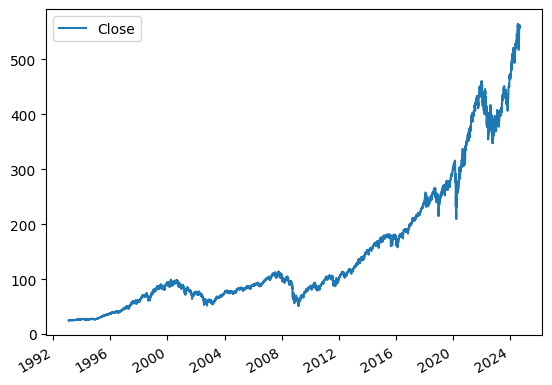

In [3]:
import matplotlib 

#Plot out spy history
spy_hist.plot.line(y="Close", use_index=True)

In [4]:
# Ensure we know the actual closing price
data = spy_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = spy_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

data.tail()

,Actual_Close,Target
2024-08-21 04:00:00,560.619995,1.0
2024-08-22 04:00:00,556.219971,0.0
2024-08-23 04:00:00,562.130005,1.0
2024-08-26 04:00:00,560.789978,0.0
2024-08-27 04:00:00,561.559998,1.0


In [5]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
spy_prev = spy_hist.copy()
spy_prev = spy_prev.shift(1)

spy_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
1993-01-29 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01 05:00:00,24.701669,24.701669,24.578775,24.684113,1003200.0,0.0,0.0,0.0
1993-02-02 05:00:00,24.701651,24.859657,24.701651,24.859657,480500.0,0.0,0.0,0.0
1993-02-03 05:00:00,24.842119,24.929900,24.789450,24.912344,201300.0,0.0,0.0,0.0
1993-02-04 05:00:00,24.947445,25.193233,24.929889,25.175676,529400.0,0.0,0.0,0.0


In [6]:
data.head() # Check to see the state of the dataframe prior to proceeding (confirming Target has been added)

,Actual_Close,Target
1993-01-29 05:00:00,24.684113,NaN
1993-02-01 05:00:00,24.859657,1.0
1993-02-02 05:00:00,24.912344,1.0
1993-02-03 05:00:00,25.175676,1.0
1993-02-04 05:00:00,25.281021,1.0


In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

# Define your base predictors first
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Join the shifted data (previous day's prices) with the current data
data = data.join(spy_prev[predictors], rsuffix='_prev').iloc[1:]

# Utilizing Rolling means to evaluate current price against the avg. price weekly, quarterly, or yearly using Pandas rolling avg. method on the Close column 
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

# We can also tell the algorithm how many days in the last week the price has gone up. We can do this by using the pandas shift and rolling methods
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

# Add the ratios between the weekly, quarterly, and annual means to the close
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

# Add in the ratios between different rolling means. This helps the algorithm understand what the weekly trend is relative to the annual trend.
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

# Add our weekly trend into the predictor DataFrame
data["weekly_trend"] = weekly_trend

# Add some ratios between intraday open, low, and high prices and the close price.
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

# Update our predictors list with all of the new predictors we added.
full_predictors = predictors + [
    "weekly_mean", "quarterly_mean", "annual_mean", 
    "annual_weekly_mean", "annual_quarterly_mean", 
    "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"
]

# Note: When accessing previous day values later in your code, use the _prev suffix, e.g., "Close_prev"

In [39]:
# Define the backtest function with an adjustable threshold and step size
def backtest(data, spy_model, predictors, start=1000, step=750, threshold=0.6):
    predictions = []  # Initialize an empty list to store predictions
    
    # Loop over the dataset in increments defined by 'step'
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()  # Create the training set
        test = data.iloc[i:(i+step)].copy()  # Create the testing set

        spy_model.fit(train[predictors], train["Target"])  # Train the model

        preds = spy_model.predict_proba(test[predictors])[:, 1]  # Predict probabilities
        preds = pd.Series(preds, index=test.index)  # Convert to pandas Series for easier manipulation
        preds[preds > threshold] = 1  # Apply the threshold for classification
        preds[preds <= threshold] = 0  # Apply the threshold for classification

        # Combine the actual targets with the predictions
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        
        predictions.append(combined)  # Append the results to the predictions list

    return pd.concat(predictions)  # Concatenate all the predictions together

# Create the RandomForest model
spy_model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=13,
    min_samples_leaf=1,
    max_depth=20,
    max_features="sqrt",
    random_state=1
)

# Run the backtest function with the adjusted step size and threshold
predictions = backtest(data, spy_model, full_predictors, start=1000, step=750, threshold=0.7)

In [40]:
# Evaluate the precision score
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Precision Score: {precision}")

Precision Score: 0.6716417910447762


In [41]:
# Check how many trades would have been made
trade_counts = predictions["Predictions"].value_counts()
print(f"Trade Counts:\n{trade_counts}")

Trade Counts:
Predictions
0.0    6883
1.0      67
Name: count, dtype: int64


<Axes: title={'center': 'Last 100 Predictions'}>

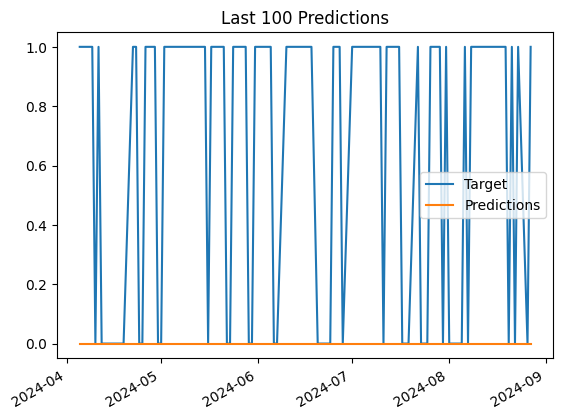

In [42]:
# Plot the last 100 predictions to visualize the model's performance
predictions.iloc[-100:].plot(title="Last 100 Predictions")

In [43]:
# Optional: Check feature importance if needed
importances = spy_model.feature_importances_
feature_importance = pd.Series(importances, index=full_predictors).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
 weekly_mean              0.090744
low_close_ratio          0.087357
open_close_ratio         0.083856
quarterly_mean           0.083564
Volume                   0.082473
high_close_ratio         0.081817
annual_mean              0.073719
annual_quarterly_mean    0.073450
annual_weekly_mean       0.072569
Open                     0.062455
Low                      0.061616
High                     0.060055
Close                    0.059988
weekly_trend             0.026336
dtype: float64


In [44]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
